## Dormancy prediction using LSTMs in Keras 

This effort is to build a LSTM model that takes as user telecom behaviour as a sequence and output the probability of becoming dormancy. The user behaviour will be enclosed in to a vector for a perticuler time sequance (weekly) which is inspired by the word vec concept.

The hardest part is the data preperation. Lets prepare the data

Lets import the required libraries

In [1]:
% pylab inline 

import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading data
df = pd.read_csv('Data\smpl.csv')
df = df.drop(df.columns[0], axis=1)

# calculationg total voice duration column
df['total']= df.mo + df.mt

df.head();

Lets check the distribution

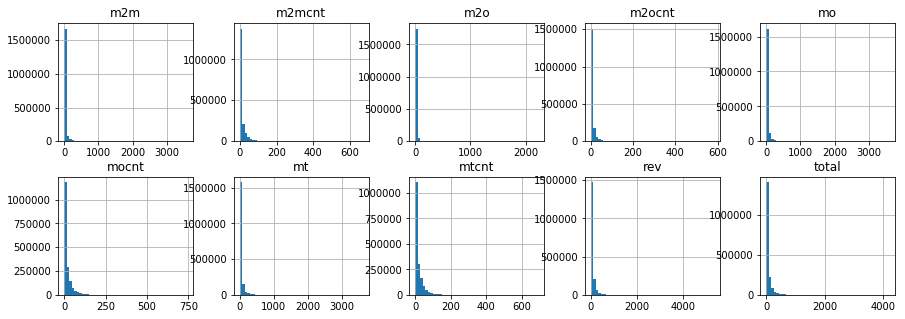

In [3]:
fig, axs = plt.subplots(2,5,figsize = (15,5))
df.loc[:,'mo':].hist(bins=50,ax = axs);

We have taken random 100K subscribers and their aggregated voice behaviour for last 18 weeks. The user behaviour is summerized weekly for
* origination call duration
* termination call duration
* on-net duration
* off-net duration
* number of origination calls
* number termination calls
* number of on-net calls
* number of off-net calls
* revenue from voice calls

Since the distribution of variables are right skewed lets try with log transformation. 

We need to scale the features. We are going to scale one feature for all the weeks and all the subscribers. This will reflect the trends of usage over the weeks as well.

In order to scale the features range [0,1] lets use sk learn MinMaxScaler

finally data will be reshaped (number of examples, number of weeks, number of features

In [4]:
# shape of the data
m = df['MSISDN'].unique().shape[0]
Tx = df['Week'].unique().shape[0]

print('There are %d number of customers and %d time steps (weeks) in our data.' % (m, Tx))

# sorting
df = df.set_index(['MSISDN', 'Week'])
df.sort_index(inplace=True)
f = df.shape[1] # number of features

# log transformation and scaling

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
nf = scaler.fit_transform(df.transform(lambda x: np.log(x+1)))

# reshaping the data to suite with keras
nf = nf.reshape(m,Tx,f)

There are 100000 number of customers and 18 time steps (weeks) in our data.


What is the distribuition look like after the scaling

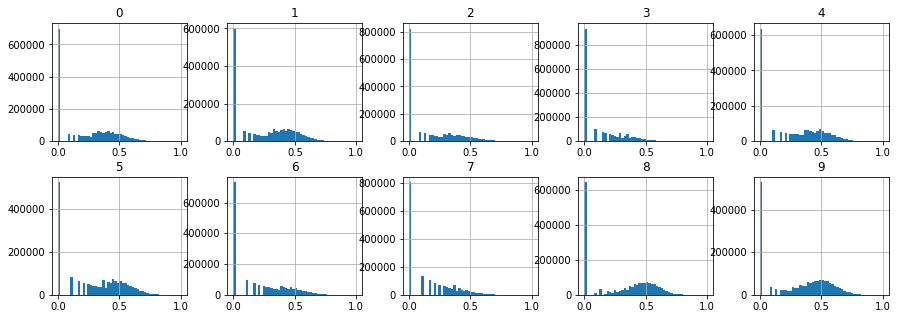

In [5]:
fig, axs = plt.subplots(2,5,figsize = (15,5))
pd.DataFrame(nf.reshape(m*Tx,f)).hist(bins=50,ax = axs);

### Churn definition
* Customer is churned if he has zero voice usage(incoming and outgoing) for most recent four weeks
* Customer should have voice usage during the week that model will be executed. This is to make sure that customer is active in the week that model is doing the prediction

#### steps
* First we will remove the customers who have churned already with reference to the week that we are going to execute the model.
* Now we need to prepare the lable. Customers who has 0 usage in recent four weeks are defined as churned, others are active

In [6]:
# filtering out the already churned candidates
X = nf[np.invert(np.all(nf[:,-5:,-1]==0,axis=1)),:-4,:]

# preparing the lable 1: churned
y = np.zeros([X.shape[0],1])
y[np.all(X[:,-4:,-1]==0,axis=1),:] = 1

print('batch size :%d , time steps : %d, vec sizes are %d :' % (X.shape[0],X.shape[1],X.shape[2]))
print('number of churned customers are :%d' % np.sum(y))

# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)

print('The base accuracy is of train set is :', 1-(np.sum(y_test)/y_test.shape[0]))
print('The base accuracy is of test set is :', 1-(np.sum(y_test)/y_test.shape[0]))

batch size :82749 , time steps : 14, vec sizes are 10 :
number of churned customers are :6506
The base accuracy is of train set is : 0.921355375097
The base accuracy is of test set is : 0.921355375097


## RNN : Using LSTMs in Keras:
Let's build an LSTM model that takes weekly usage behaviour as sequence. 

Lets load the Keras packages.

This model is having two LSTM layers with 128 hidden units

In [7]:
#loading required libraries
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout, LSTM, Activation

Using TensorFlow backend.


In [8]:
random.seed(1)

model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(X.shape[1],X.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.summary();

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 14, 128)           71168     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 202,881
Trainable params: 202,881
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Lets train the model for 2 epochs

In [10]:
model.fit(X_train, y_train, epochs = 2, batch_size = 32, shuffle=True,validation_data=(X_test,y_test));

Train on 62061 samples, validate on 20688 samples
Epoch 1/2
62061/62061 [==============================] - 126s - loss: 0.0358 - acc: 0.9871 - val_loss: 0.0100 - val_acc: 0.9954
Epoch 2/2
62061/62061 [==============================] - 125s - loss: 0.0077 - acc: 0.9973 - val_loss: 0.0038 - val_acc: 0.9986
